In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import random as rn
import csv
import os
import cv2
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [2]:
# tensorflowの乱数シード固定(再現性の担保)
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(7)
rn.seed(7)

session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

tf.set_random_seed(7)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [3]:
batch_size = 32
n_epochs = 50

# 画像データ取り込み


In [4]:
DATA_FOLDER = '/home/tamaru/scene_categorize/main/data'
datalist = pd.read_csv(os.path.join(DATA_FOLDER, 'resized_data.csv'), names=["img_path", "l_class", 's_class','timestamp'])
datalist.head()

,img_path,l_class,s_class,timestamp
0,/home/tamaru/scene_categorize/main/data/insta_...,5gokan-denkisogokan,5gokan-denkisogokan,NaN
1,/home/tamaru/scene_categorize/main/data/insta_...,5gokan-denkisogokan,5gokan-denkisogokan,NaN
2,/home/tamaru/scene_categorize/main/data/insta_...,5gokan-denkisogokan,5gokan-denkisogokan,NaN
3,/home/tamaru/scene_categorize/main/data/insta_...,5gokan-denkisogokan,5gokan-denkisogokan,NaN
4,/home/tamaru/scene_categorize/main/data/insta_...,5gokan-denkisogokan,5gokan-denkisogokan,NaN


In [5]:
dfs = datalist.drop(['l_class', 'timestamp'], axis=1)
dfs.groupby('s_class').count()

,img_path
s_class,
4gokan_inside,42
4gokan_outside_east,18
4gokan_outside_west,248
4gokan_stairs,750
5gokan-denkisogokan,361
5gokan-mediacenter,127
5gokan_1F,65
5gokan_2F,96
5gokan_3F,32


In [6]:
dfs.img_path.count()

8930

In [7]:
num_s_class = len(dfs.s_class.unique())
num_s_class

36

In [8]:
grad_test_img_path =[
    "/home/tamaru/scene_categorize/main/data/insta_resized/4gokan/4gokan_inside/4gokan_inside_0_img_000240.png",
    "/home/tamaru/scene_categorize/main/data/insta_resized/4gokan/4gokan_outside/4gokan_outside_0_img_000180.png",
    "/home/tamaru/scene_categorize/main/data/insta_resized/5gokan-denkisogokan/5gokan-denkisogokan_1_img_000010.png",
    "/home/tamaru/scene_categorize/main/data/insta_resized/5gokan-mediacenter/5gokan-mediacenter_0_img_000030.png",
    "/home/tamaru/scene_categorize/main/data/insta_resized/5gokan/5gokan_1F/5gokan_1F_0_img_000070.png",
    "/home/tamaru/scene_categorize/main/data/insta_resized/5gokan/5gokan_2F/5gokan_2F_2_img_000030.png",
    "/home/tamaru/scene_categorize/main/data/insta_resized/5gokan/5gokan_3F/5gokan_3F_0_img_000040.png",
    "/home/tamaru/scene_categorize/main/data/insta_resized/5gokan/5gokan_ent_east/5gokan_ent_east_2_img_000000.png",
    "/home/tamaru/scene_categorize/main/data/insta_resized/5gokan/5gokan_lounge/5gokan_lounge_2_img_000060.png",
    "/home/tamaru/scene_categorize/main/data/insta_resized/5gokan/5gokan_out_east/5gokan_out_east_0_img_000270.png",
    "/home/tamaru/scene_categorize/main/data/insta_resized/5gokan/5gokan_parking/5gokan_parking_1_img_000170.png",
    "/home/tamaru/scene_categorize/main/data/insta_resized/5gokan/5gokan_smoking/5gokan_smoking_0_img_000270.png",
    "/home/tamaru/scene_categorize/main/data/insta_resized/5gokan/5gokan_stairs_cnt/5gokan_stairs_cnt_3_img_000010.png",
    "/home/tamaru/scene_categorize/main/data/insta_resized/5gokan/5gokan_stairs_west/5gokan_stairs_west_0_img_000340.png",
    "/home/tamaru/scene_categorize/main/data/insta_resized/8gokan/8gokan_1F/8gokan_1F_1_img_000000.png",
    "/home/tamaru/scene_categorize/main/data/insta_resized/8gokan/8gokan_ent_north/8gokan_ent_north_0_img_000010.png",
    "/home/tamaru/scene_categorize/main/data/insta_resized/8gokan/8gokan_ent_south/8gokan_ent_south_1_img_000070.png",
    "/home/tamaru/scene_categorize/main/data/insta_resized/denkisogokan/denkisogokan_2F/denkisogokan_2F_2_img_000300.png",
    "/home/tamaru/scene_categorize/main/data/insta_resized/denkisogokan/denkisogokan_3F/denkisogokan_3F_0_img_000010.png",
    "/home/tamaru/scene_categorize/main/data/insta_resized/denkisogokan/denkisogokan_4F/denkisogokan_4F_0_img_000170.png",
    "/home/tamaru/scene_categorize/main/data/insta_resized/denkisogokan/denkisogokan_elevator/denkisogokan_elevator_0_img_000220.png",
    "/home/tamaru/scene_categorize/main/data/insta_resized/denkisogokan/denkisogokan_lounge/denkisogokan_lounge_1_img_000060.png",
    "/home/tamaru/scene_categorize/main/data/insta_resized/denkisogokan/denkisogokan_stairs/denkisogokan_stairs_0_img_000120.png",
    "/home/tamaru/scene_categorize/main/data/insta_resized/lab-lounge/lab-lounge_0_img_000170.png",
    "/home/tamaru/scene_categorize/main/data/insta_resized/lab/lab_bs_cnt/lab_bs_cnt_0_img_000270.png",
    "/home/tamaru/scene_categorize/main/data/insta_resized/lab/lab_corner/lab_corner_0_img_000270.png",
    "/home/tamaru/scene_categorize/main/data/insta_resized/lab/lab_desk/lab_desk_8_img_000210.png",
    "/home/tamaru/scene_categorize/main/data/insta_resized/lab/lab_desk_table/lab_desk_table_3_img_000150.png",
    "/home/tamaru/scene_categorize/main/data/insta_resized/lab/lab_ent/lab_ent_0_img_000020.png",
    "/home/tamaru/scene_categorize/main/data/insta_resized/lab/lab_printer/lab_printer_0_img_000030.png",
    "/home/tamaru/scene_categorize/main/data/insta_resized/lab/lab_table/lab_table_0_img_000170.png",
    "/home/tamaru/scene_categorize/main/data/insta_resized/lab/lab_wb_cnt/lab_wb_cnt_0_img_000120.png",
    "/home/tamaru/scene_categorize/main/data/insta_resized/lab/lab_wb_ent/lab_wb_ent_1_img_000160.png",
    "/home/tamaru/scene_categorize/main/data/insta_resized/lounge/lounge_1_img_000060.png",
]

In [9]:
# Markdown
from sklearn.preprocessing import LabelEncoder

In [10]:
# Markdown
le = LabelEncoder()
le.fit(dfs.s_class)
dfs["labels"] = le.transform(dfs.s_class)
dfs.groupby('labels')

In [11]:
# Markdown
cor_table = dfs.groupby('labels').s_class.unique()
cor_table = pd.DataFrame(cor_table)
cor_table.head()

,s_class
labels,
0,[4gokan_inside]
1,[4gokan_outside_east]
2,[4gokan_outside_west]
3,[4gokan_stairs]
4,[5gokan-denkisogokan]


In [12]:
# Markdown
dfs = dfs.drop(['s_class'], axis=1)

In [13]:
# Markdown
x = []
for i in range(len(dfs.img_path)):
    image = img_to_array(load_img(dfs.img_path[i], target_size=(224,224)))
    x.append(image)

In [14]:
# Markdown
y = dfs.labels

0        4
1        4
2        4
3        4
4        4
5        4
6        4
7        4
8        4
9        4
10       4
11       4
12       4
13       4
14       4
15       4
16       4
17       4
18       4
19       4
20       4
21       4
22       4
23       4
24       4
25       4
26       4
27       4
28       4
29       4
        ..
8900    11
8901    11
8902    11
8903    11
8904    11
8905    11
8906    11
8907    11
8908    11
8909    11
8910    11
8911    11
8912    11
8913    11
8914    11
8915    11
8916    11
8917    11
8918    11
8919    11
8920    11
8921    11
8922    11
8923    11
8924    11
8925    11
8926    11
8927    11
8928    11
8929    11
Name: labels, Length: 8930, dtype: int64


In [15]:
# Markdown
#正規化
x = np.array(x, dtype='float32')/255

# train test & validation set split

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
x, x_valid, y, y_valid = train_test_split(x,y, random_state=42, test_size=0.2, stratify=y)

# EDA(探索的データ解析)


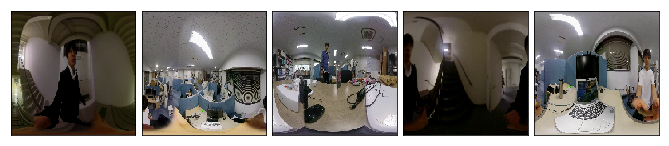

In [18]:
fig = plt.figure(figsize=(9,18))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05, wspace=0.05)
for i in range(5):
    ax = fig.add_subplot(1, 5, i+1, xticks=[], yticks=[])
    ax.imshow(x[i])

# BagNets17　Using VGG16

In [19]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Activation, add, Add, Dropout, BatchNormalization, GlobalMaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

In [20]:
import bagnets.kerasnet
from tensorflow.keras.applications.vgg16 import VGG16

Using TensorFlow backend.


In [21]:
from metrics import *
from scheduler import *

In [22]:
# vgg_model = bagnets.kerasnet.bagnet17()
vgg_model = VGG16(weights=None, include_top=False, input_shape=(224,224,3))
weight_decay = 1e-4

Instructions for updating:
Colocations handled automatically by placer.


In [23]:
vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [24]:
x = vgg_model.output
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Flatten()(x)
x = Dense(512, kernel_initializer='he_normal',
            kernel_regularizer=regularizers.l2(weight_decay))(x)
x = BatchNormalization()(x)
output = ArcFace(num_s_class, regularizer=regularizers.l2(weight_decay))([x, y])
full_model = Model(inputs=vgg_model.input, outputs=prediction)

for layer in full_model.layers[:15]:
    layer.trainable = False

early_stopping = EarlyStopping(monitor='val_loss', verbose=1, mode='auto')
full_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


TypeError: unsupported operand type(s) for /: 'Dimension' and 'float'

In [ ]:
full_model.summary()

   # 層化抽出法(Stratified sampling)&KFold

In [ ]:
from sklearn.model_selection import StratifiedKFold
from keras.utils import np_utils

In [ ]:
skf = StratifiedKFold(n_splits=5, random_state=42)
cvscores = []
#Stratified KFoldはlabel encoding化した整数ベクトルでないともちいることができない
x = np.array(x)
y = np.array(y)
for train_index, test_index in skf.split(x, y):
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #One-hot化　CNNに入出力できるように整形
    y_train = np_utils.to_categorical(y_train, num_s_class)
    y_test = np_utils.to_categorical(y_test, num_s_class)
    full_model.fit(x_train, y_train, verbose=1, batch_size=batch_size, epochs=n_epochs,
              callbacks=[early_stopping], validation_split=0.2)
    scores = full_model.evaluate(x_test, y_test)
    print("%s: %.2f%%" % (full_model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)

In [ ]:
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

In [ ]:
y_pred = full_model.predict(x_valid)

In [ ]:
y_valid = np_utils.to_categorical(y_valid)

In [ ]:
y_pred = np.array(y_pred)
y_true = np.array(y_valid)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_true, axis=1)

# Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from scipy.sparse.csgraph import connected_components

In [ ]:
cmx = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12,12))
sns.heatmap(cmx, annot=True)
plt.show()
print('accuracy: {}'.format(accuracy_score
(y_true, y_pred)))

In [ ]:
cor_table = pd.read_csv('cor_table.csv')
print(cor_table)

# grad-cam

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

In [ ]:
true = []
for i in range(num_s_class):
    true.append(i)

In [ ]:
pred = []

grad_last_conv = full_model.get_layer("block5_conv3")
model_output = full_model.output[:,0]
grads = K.gradients(model_output, grad_last_conv.output)[0]
pooled_grads = K.mean(grads, axis=(0,1,2))
iterate = K.function([full_model.input], [pooled_grads, grad_last_conv.output[0]])

for n in range(len(grad_lab_img)):
    img_keras = image.load_img(grad_lab_img[n], target_size=(224, 224))
    img_tensor = image.img_to_array(img_keras)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    predicts = full_model.predict(img_tensor)
    s_class_num = np.argmax(predicts)
    pred.append(s_class_num)
    img_tensor /= 255.
    pooled_grads_val, conv_output_val = iterate([img_tensor])
    for i in range(pooled_grads_val.shape[0]):
        conv_output_val[:, :, i] *= pooled_grads_val[i]
    heatmap = np.mean(conv_output_val, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    img = cv2.imread(grad_lab_img[n])
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * 0.4 + img
    save_dir = '../data/gradcam_img/VGG16'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)	# Make a directory
    #保存先ディレクトリ名はその画像のクラス，画像の予測値を画像の名前に書き込む
    cv2.imwrite(save_dir+'/heatmap_wrong_pred_'+s_classlist[s_class_num]+'_'+str(n)+'_'+'.jpg', superimposed_img)
    print('Saved: ', save_dir+'/heatmap_wrong_pred_'+s_classlist[s_class_num]+'.jpg')

def grad_cam(input_model, image, cls, layer_name):
    """GradCAM method for visualizing input saliency."""
    y_c = input_model.output[0, cls]
    conv_output = input_model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]
    # Normalize if necessary
    # grads = normalize(grads)
    gradient_function = K.function([input_model.input], [conv_output, grads])

    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)

    # Process CAM
    cam = cv2.resize(cam, (W, H), cv2.INTER_LINEAR)
    cam = np.maximum(cam, 0)
    cam_max = cam.max() 
    if cam_max != 0: 
        cam = cam / cam_max
    return cam


for n in range(len(grad_lab_img)):
    cam = grad_cam(input_model=full_model, image=grad_lab_img[n], cls=-1, layer_name="block5_conv3")
    save_dir = '../data/gradcam_test/VGG16'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)	# Make a directory
    #保存先ディレクトリ名はその画像のクラス，画像の予測値を画像の名前に書き込む
    cv2.imwrite(save_dir+'/heatmap_wrong_pred_'+s_classlist[s_class_num]+'_'+str(n)+'_'+'.jpg', cam)
    print('Saved: ', save_dir+'/heatmap_wrong_pred_'+s_classlist[s_class_num]+'.jpg')

In [ ]:
df_grad = pd.DataFrame(grad_lab_img)
df_grad

In [ ]:
cmx = confusion_matrix(true, pred)
plt.figure(figsize=(12,12))
sns.heatmap(cmx, annot=True)
plt.ylabel("truth")
plt.xlabel("prediction")
plt.show()

In [ ]:
cor_table = pd.read_csv('cor_table.csv')
print(cor_table)

prediction->edge ==> padding